In [1]:
# This notebook takes convergence and shear maps from published global lens models
# and calculates correspoding CAB parameters to compare with our independent CAB.

# Cluster: SMACS 0723

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import imshow_norm
from matplotlib.colors import LogNorm
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u

In [3]:
# Comparing to global lens model by Caminha 2022
# Files came from: https://cdsarc.u-strasbg.fr/ftp/J/A+A/666/L9/files/maps_Dls_over_Ds_1/

path = "/n/home02/nephremidze/spring/4-May/global-model-to-cab/Caminha-2022-smacs0723/"

kappa_file = path+'kappa0_rel.fits'
shear_file = path+'shear0_rel.fits'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


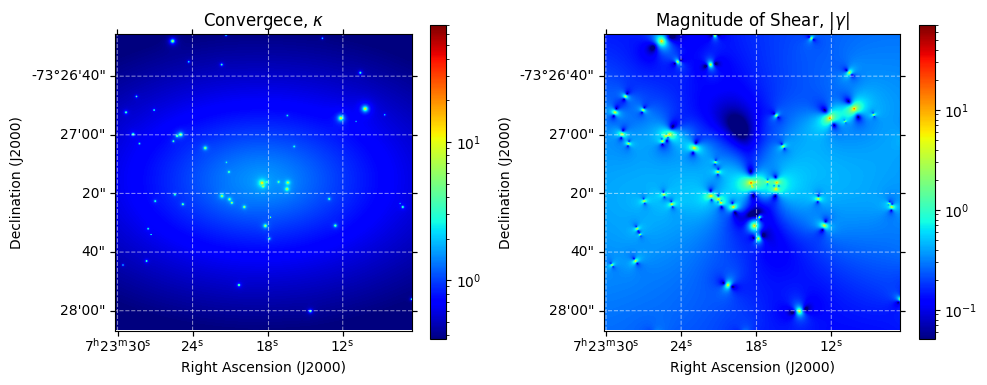

In [4]:
# Plot the convergence and shear field

def plot_maps(data_arrays, wcs_list, titles, num):
    fig, axes = plt.subplots(1, num, figsize=(5*num, 4), subplot_kw={'projection': wcs_list[0]})

    if num == 1:
        axes = [axes] 
        
    for i in range(num):
        axes[i].remove()  
        ax = fig.add_subplot(1, num, i+1, projection=wcs_list[i])
        norm = LogNorm(vmin=data_arrays[i].min()+0.05, vmax=data_arrays[i].max()+0.05)  # LogNorm for scaling
        img = ax.imshow(data_arrays[i], origin='lower', norm=norm, cmap='jet')
        
        cbar = plt.colorbar(img, ax=ax, orientation='vertical')
        
        ax.set_xlabel('Right Ascension (J2000)')
        ax.set_ylabel('Declination (J2000)')
        
        ax.grid(color='white', linestyle='--', alpha=0.5)
        
        ax.set_title(titles[i])
    
    plt.tight_layout()
    plt.show()

# Convergence
with fits.open(kappa_file) as hdul:
    kappa_data = hdul[0].data
    wcs_k = WCS(hdul[0].header)

# Magnitude of shear
with fits.open(shear_file) as hdul:
    shear_data = hdul[0].data
    wcs_g = WCS(hdul[0].header)
    
# Plot Convergence and Shear
plot_maps([kappa_data, shear_data], [wcs_k, wcs_g], ['Convergece, $\kappa$', 'Magnitude of Shear, $|\gamma|$'], 2)

In [5]:
# Makes cutouts centered at given RA and DEC, using World Coordinate System (WCS), of specified size in arcsec.
def make_cutout(data, wcs, ra, dec, size):
    coord = SkyCoord(ra, dec, unit=(u.deg, u.deg), frame='icrs')
    size = u.Quantity((size, size), u.arcsec)
    cutout = Cutout2D(data, position=coord, size=size, wcs=wcs)
    return cutout

In [6]:
# Let's calculate the lensing Jacobian A around the lensed image positions.
# The tangential and radial stretches are 1/(eigenvalues) of A.

Set DATE-AVG to '2022-06-07T06:27:17.412' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.538' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915275 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675664703.439 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


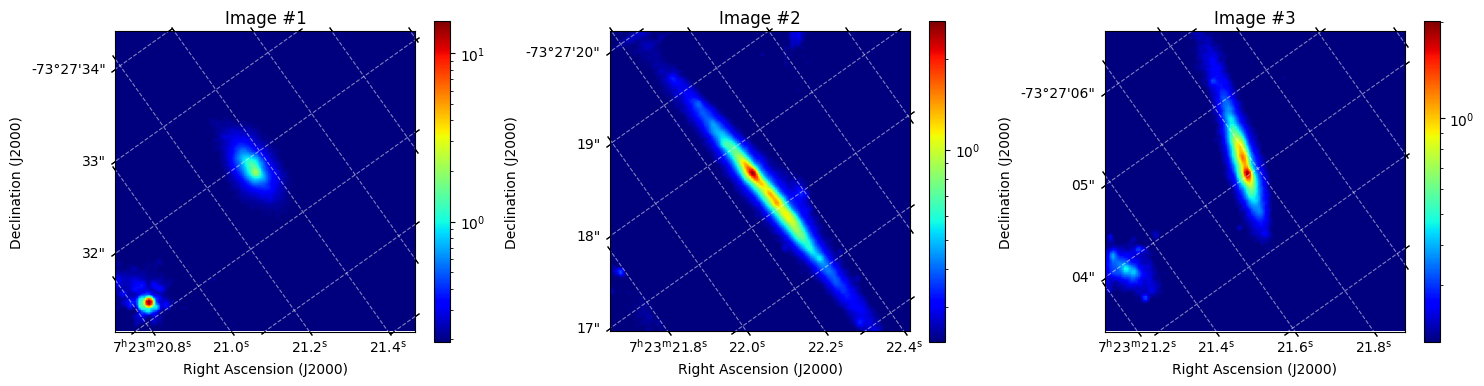

In [7]:
# Position of SMACS System 1 lensed images:
coordinates = [(110.8389887, -73.4587844),  # Image 1
                (110.8429489, -73.4548399), # Image 2
                (110.8407240, -73.4510787)] # Image 3

# Just to make sure we have the correct positions, let's plot these cutouts from the SMACS JWST image
smacs_file = "/n/holyscratch01/dvorkin_lab/nephremidze/JWST-CAB-systems/SMACS-0723/jw02736-o001_t001_nircam_clear-f200w_i2d.fits"
with fits.open(smacs_file) as hdul:
    smacs_data = hdul[1].data
    smacs_wcs = WCS(hdul[1].header)

size = 4 # again in arcseconds

smacs_cutouts = []
smacs_WCSs = []

for i in range(len(coordinates)):
    
    ra, dec = coordinates[i]
    smacs_cutout = make_cutout(smacs_data, smacs_wcs, ra, dec, size)
    smacs_cutouts.append(smacs_cutout.data)
    smacs_WCSs.append(smacs_cutout.wcs)
    
titles = ["Image #1", "Image #2", "Image #3"]
plot_maps(smacs_cutouts, smacs_WCSs, titles, 3)

In [8]:
phi = 0 # The tangential and radial stretch are coordinate-system invariant.
        # We can work in the basis where A is already diagonal, so phi = 0.

kappa_field = kappa_data
gamma1_field = np.cos(2*phi) * shear_data
gamma2_field = np.sin(2*phi) * shear_data

In [9]:
size = 4 # roughly the size of lensed image cutouts we analyzed with CAB, in arcsecond

kappa_cutouts = []
gamma1_cutouts = []
gamma2_cutouts = []

for i in range(len(coordinates)):
        
    ra, dec = coordinates[i]

    kappa_cutout = make_cutout(kappa_field, wcs_k, ra, dec, size)
    gamma1_cutout = make_cutout(gamma1_field, wcs_g, ra, dec, size)
    gamma2_cutout = make_cutout(gamma2_field, wcs_g, ra, dec, size)
    
    kappa_cutouts.append(kappa_cutout)
    gamma1_cutouts.append(gamma1_cutout)
    gamma2_cutouts.append(gamma2_cutout)

Convergence Maps:


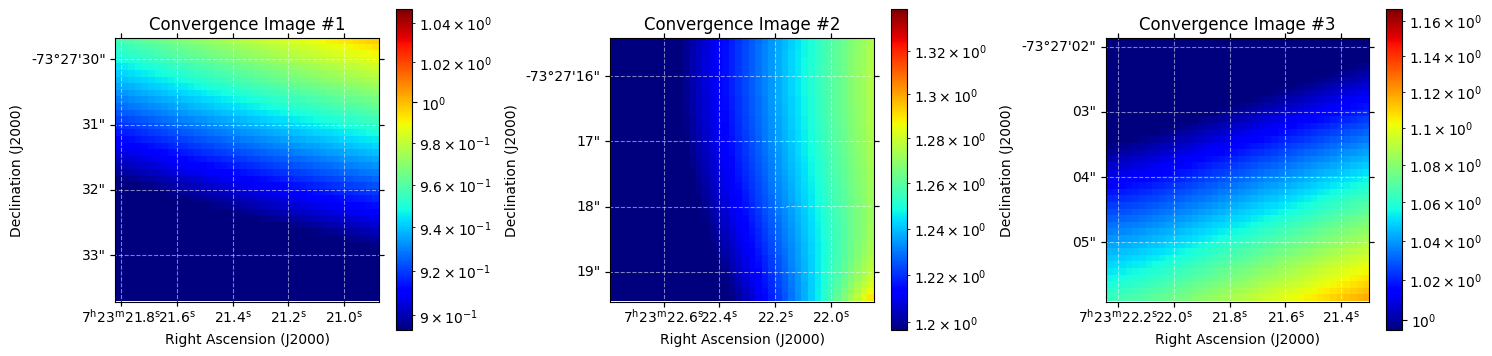

Shear Maps:


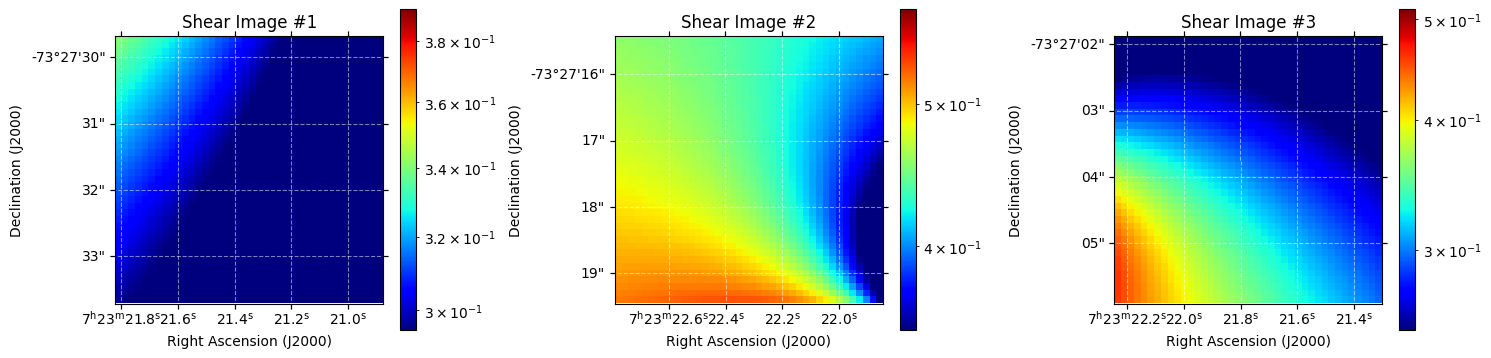

In [10]:
# Let's plot the cutouts of the convegrence and shear maps at the lensed image coordinates

print("Convergence Maps:")
plot_maps([kappa_cutouts[0].data, kappa_cutouts[1].data, kappa_cutouts[2].data],
          [kappa_cutouts[0].wcs, kappa_cutouts[1].wcs, kappa_cutouts[2].wcs],
          ["Convergence Image #1", "Convergence Image #2", "Convergence Image #3"], 3)

print("Shear Maps:")
plot_maps([gamma1_cutouts[0].data, gamma1_cutouts[1].data, gamma1_cutouts[2].data],
          [gamma1_cutouts[0].wcs, gamma1_cutouts[1].wcs, gamma1_cutouts[2].wcs],
          ["Shear Image #1", "Shear Image #2", "Shear Image #3"], 3)

In [11]:
# The matrix of the lensing Jacobians at each pixel in the cutout region

lambda_rads = []
lambda_tans = []

for i in range(len(coordinates)):
    
    ks = kappa_cutouts[i].data
    g1s = gamma1_cutouts[i].data
    g2s = gamma2_cutouts[i].data
    
    A_matrix_field = np.array([[1-ks-g1s, -g2s    ],
                               [-g2s,     1-ks+g1s]])
    
    #print(np.shape(A_matrix_field))
    
    A00 = np.mean(A_matrix_field[0, 0, :, :])
    A01 = np.mean(A_matrix_field[0, 1, :, :])
    A10 = np.mean(A_matrix_field[1, 0, :, :])
    A11 = np.mean(A_matrix_field[1, 1, :, :])

    A = np.array([[A00, A01],
                  [A10, A11]])

    eig_vals, eig_vecs = np.linalg.eig(A)
    #print(eig_vals)
    #print(eig_vecs)

    lambdas = 1/eig_vals
    lambda_rad = np.min(np.abs(lambdas))
    lambda_tan = np.max(np.abs(lambdas))
    
    lambda_rads.append(lambda_rad)
    lambda_tans.append(lambda_tan)

lambda_tans /= lambda_rads[0]
lambda_rads /= lambda_rads[0]

print("Radial stretches: \t", np.round(lambda_rads, 2))
print("Tangential stretches: \t", np.round(lambda_tans, 2))

Radial stretches: 	 [1.   0.56 1.14]
Tangential stretches: 	 [1.83 1.63 1.36]


In [12]:
# Storing these values for comparison later

l_t1_c = lambda_tans[0]
l_r2_c = lambda_rads[1]
l_t2_c = -lambda_tans[1] # because our l_t2_c is negative
l_r3_c = lambda_rads[2]
l_t3_c = lambda_tans[2]

In [13]:
# Comparing to global lens model by Mahler 2023
# Files came from:
# https://github.com/guillaumemahler/SMACS0723-mahler2022/blob/main/ICLv2/tmp_k/0000_k.fits.tar.xz
# https://github.com/guillaumemahler/SMACS0723-mahler2022/blob/main/ICLv2/tmp_g/0000_g.fits.tar.xz

path = "/n/home02/nephremidze/spring/4-May/global-model-to-cab/Mahler-2023-smacs0723/"

kappa_file = path+'0000_k.fits'
shear_file = path+'0000_g.fits'

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


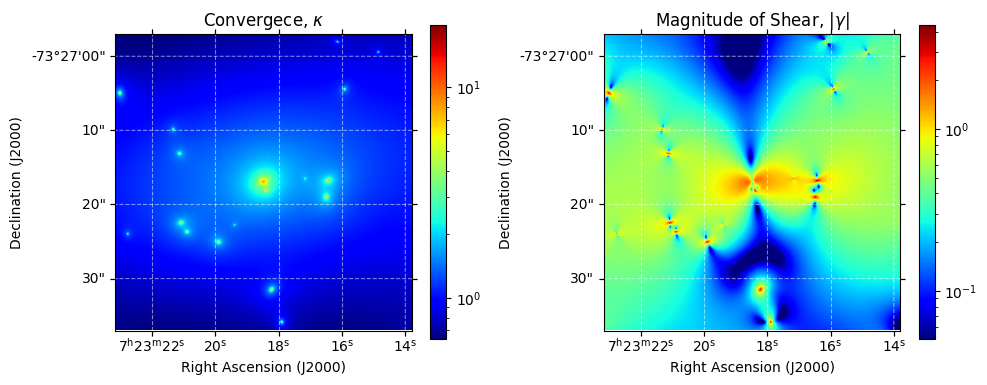

In [14]:
# Convergence
with fits.open(kappa_file) as hdul:
    kappa_data = hdul[0].data
    wcs_k = WCS(hdul[0].header)
# Plot the convergence
#plot_map(kappa_data, wcs, 'Convergece, $\kappa$')

# Magnitude of shear
with fits.open(shear_file) as hdul:
    shear_data = hdul[0].data
    wcs_g = WCS(hdul[0].header)
# Plot the shear
#plot_map(shear_data, wcs, 'Magnitude of Shear, $|\gamma|$')

plot_maps([kappa_data, shear_data], [wcs_k, wcs_g], ['Convergece, $\kappa$', 'Magnitude of Shear, $|\gamma|$'], 2)

In [15]:
phi = 0
kappa_field = kappa_data
gamma1_field = np.cos(2*phi) * shear_data
gamma2_field = np.sin(2*phi) * shear_data

In [16]:
kappa_cutouts = []
gamma1_cutouts = []
gamma2_cutouts = []

for i in range(len(coordinates)):
        
    ra, dec = coordinates[i]

    kappa_cutout = make_cutout(kappa_field, wcs_k, ra, dec, size)
    gamma1_cutout = make_cutout(gamma1_field, wcs_g, ra, dec, size)
    gamma2_cutout = make_cutout(gamma2_field, wcs_g, ra, dec, size)
    
    kappa_cutouts.append(kappa_cutout)
    gamma1_cutouts.append(gamma1_cutout)
    gamma2_cutouts.append(gamma2_cutout)

Convergence Maps:


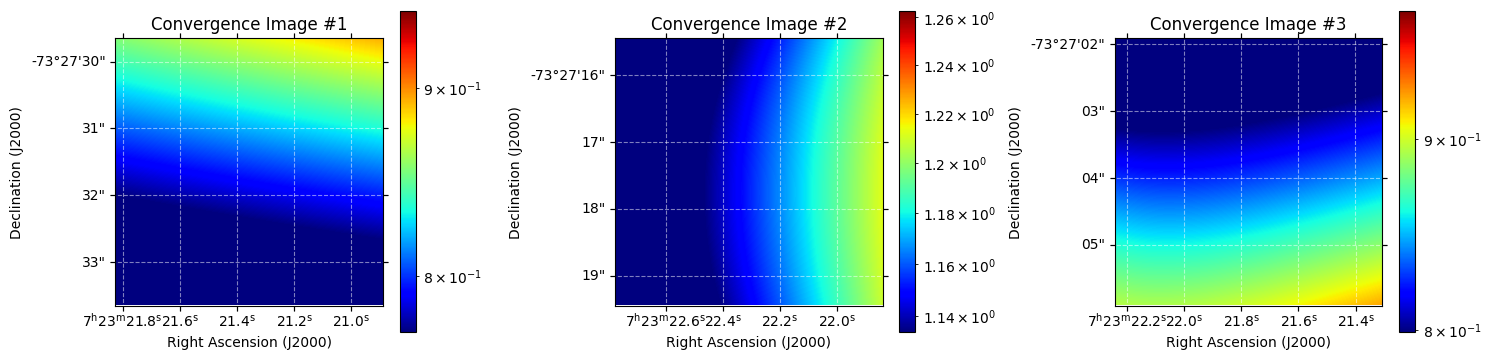

Shear Maps:


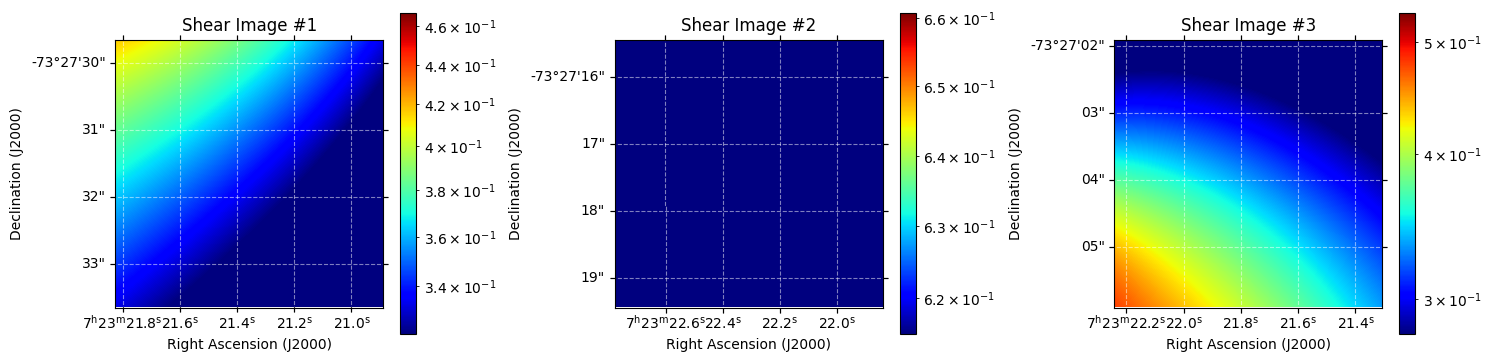

In [17]:
# Let's plot the cutouts of the convegrence and shear maps at the lensed image coordinates

print("Convergence Maps:")
plot_maps([kappa_cutouts[0].data, kappa_cutouts[1].data, kappa_cutouts[2].data],
          [kappa_cutouts[0].wcs, kappa_cutouts[1].wcs, kappa_cutouts[2].wcs],
          ["Convergence Image #1", "Convergence Image #2", "Convergence Image #3"], 3)

print("Shear Maps:")
plot_maps([gamma1_cutouts[0].data, gamma1_cutouts[1].data, gamma1_cutouts[2].data],
          [gamma1_cutouts[0].wcs, gamma1_cutouts[1].wcs, gamma1_cutouts[2].wcs],
          ["Shear Image #1", "Shear Image #2", "Shear Image #3"], 3)

In [18]:
# The matrix of the lensing Jacobians at each pixel in the cutout region

lambda_rads = []
lambda_tans = []

for i in range(len(coordinates)):
    
    ks = kappa_cutouts[i].data
    g1s = gamma1_cutouts[i].data
    g2s = gamma2_cutouts[i].data
    
    A_matrix_field = np.array([[1-ks-g1s, -g2s    ],
                               [-g2s,     1-ks+g1s]])
    
    #print(np.shape(A_matrix_field))
    
    A00 = np.mean(A_matrix_field[0, 0, :, :])
    A01 = np.mean(A_matrix_field[0, 1, :, :])
    A10 = np.mean(A_matrix_field[1, 0, :, :])
    A11 = np.mean(A_matrix_field[1, 1, :, :])

    A = np.array([[A00, A01],
                  [A10, A11]])

    eig_vals, eig_vecs = np.linalg.eig(A)
    #print(eig_vals)
    #print(eig_vecs)

    lambdas = 1/eig_vals
    lambda_rad = np.min(np.abs(lambdas))
    lambda_tan = np.max(np.abs(lambdas))
    
    lambda_rads.append(lambda_rad)
    lambda_tans.append(lambda_tan)

lambda_tans /= lambda_rads[0]
lambda_rads /= lambda_rads[0]

print("Radial stretches: \t", np.round(lambda_rads, 2))
print("Tangential stretches: \t", np.round(lambda_tans, 2))

Radial stretches: 	 [1.   0.73 1.08]
Tangential stretches: 	 [3.91 1.22 3.43]


In [19]:
l_t1_m = lambda_tans[0]
l_r2_m = lambda_rads[1]
l_t2_m = -lambda_tans[1]
l_r3_m = lambda_rads[2] 
l_t3_m = lambda_tans[2]

In [20]:
# Let's plot a comparison with CAB parameters from our analysis

import pickle
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot

# dynesty results file from 200 filter and nmax = 8
dresults_file = "/n/home02/nephremidze/spring/3-April/f200w_BIC/nino_data/results/nmax8"

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
dresults = load_obj(dresults_file)

def bestfit(result):
    #takes in the result, returns best fit and errors
    #and returns -logl
    logs = result.logl
    samps = result.samples
    argmax = np.argmax(logs)
    
    weights = np.exp(result.logwt - result.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samps, weights)
    
    errs = [cov[i,i] for i in range(len(mean))]
    
    return logs[argmax],samps[argmax],np.sqrt(errs)*2. 

maxl, bestf, cv = bestfit(dresults)

5


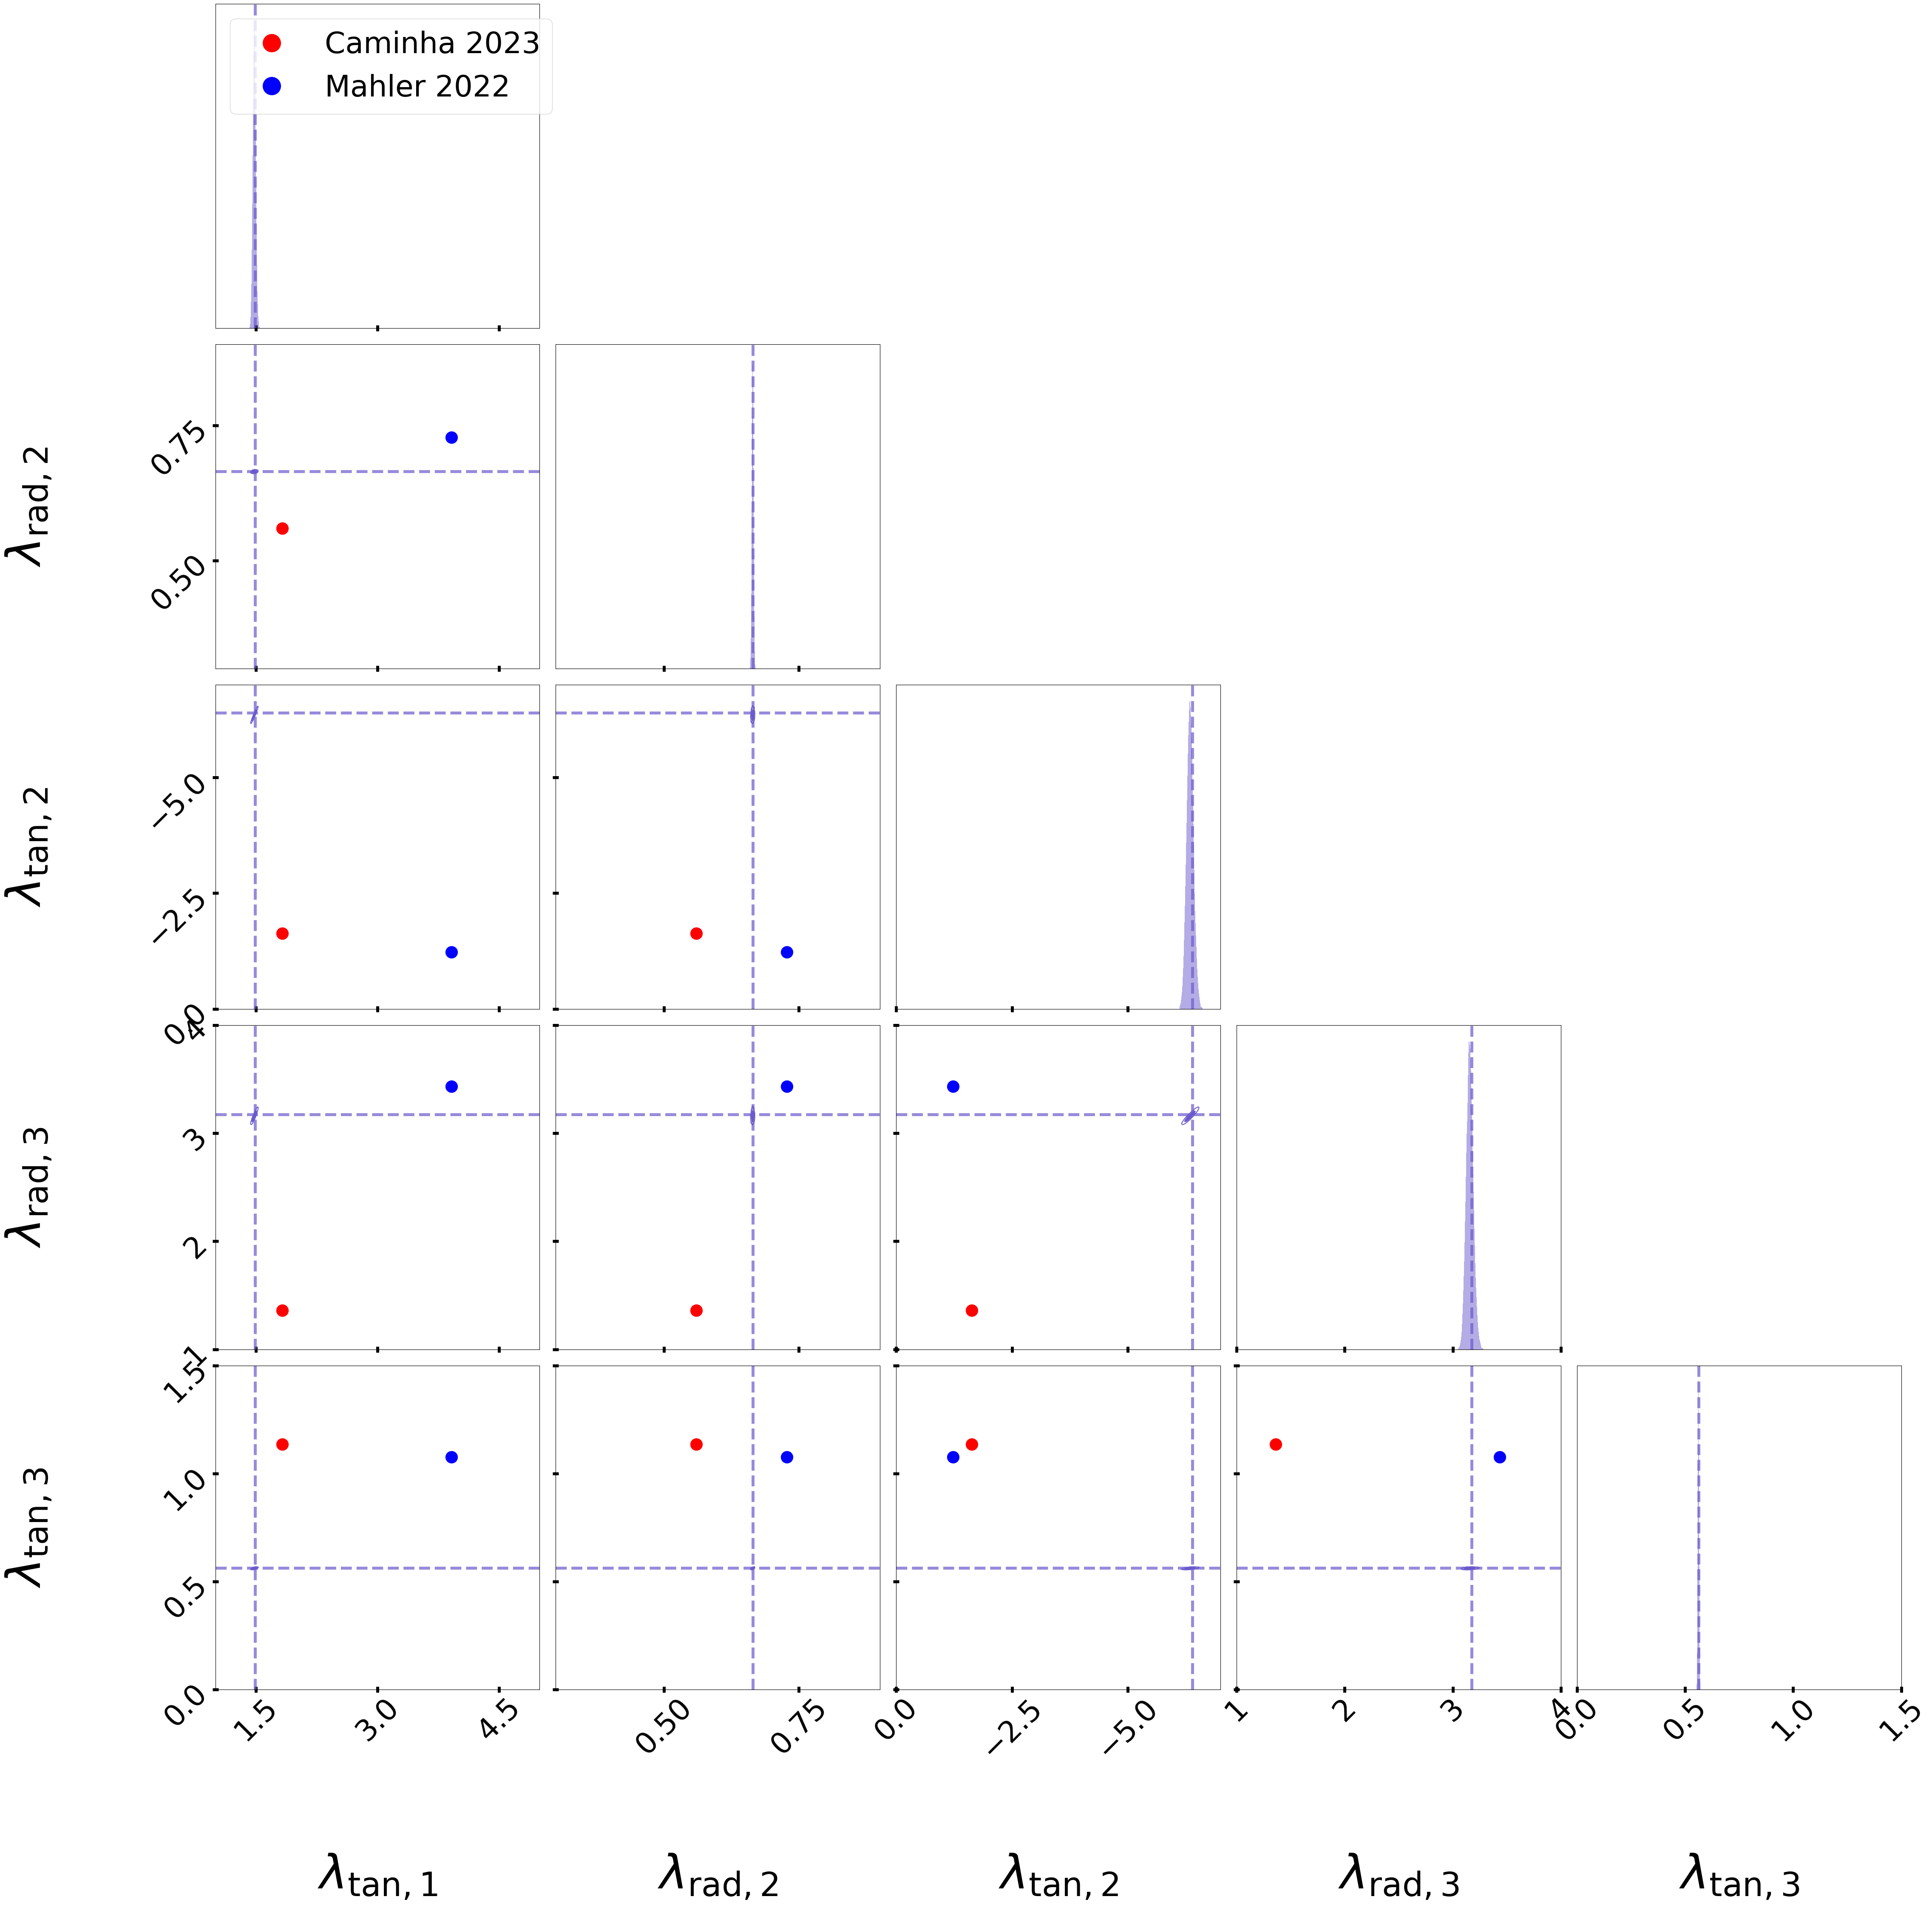

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from dynesty import plotting as dyplot

labls_mask = ['$\\lambda_{\mathrm{tan},1}$','$s_{\mathrm{tan},1}$ [arcsec$^{-1}$]','$\\phi_{1}/\pi$ ',
              '$\\lambda_{\mathrm{rad},2}$','$\\lambda_{\mathrm{tan},2}$','$\\s_{\mathrm{tan},2}$ [arcsec$^{-1}$]','$\\phi_{2}/\pi$','$\\alpha_{2,x}$ [arcsec]', '$\\alpha_{2,y}$ [arcsec]',
              '$\\lambda_{\mathrm{rad},3}$','$\\lambda_{\mathrm{tan},3}$','$\\s_{\mathrm{tan},3}$ [arcsec$^{-1}$]','$\\phi_{3}/\pi$','$\\alpha_{3,x}$ [arcsec]', '$\\alpha_{3,y}$ [arcsec]', 
              '$\\delta_1$ [arcsec]', '$x_1$ [arcsec]', '$y_1$ [arcsec]','$\\delta_2$ [arcsec]', '$x_2$ [arcsec]', '$y_2$ [arcsec]']

truedic = {'linewidth':5.,'linestyle':'dashed'}
histdic = {'density':True,'alpha':0.5}

N = 5

nlist = np.array([0, 3, 4, 9, 10])

print(len(nlist))
labels_plot = []
bestfpp = np.zeros(N)
for i in range(len(nlist)):
    labels_plot.append(labls_mask[nlist[i]])
    bestfpp[i] = bestf[nlist[i]]

tfig2, taxes2 = plt.subplots(N, N, figsize=(9*N, 9*N))

span = np.ones(N) * 0.9995

quant = [0.6826894921370859, 0.9544997361036416]

intcplot, intcbestplot = dresults, bestfpp

tfig2, _ = dyplot.cornerplot(intcplot, span=span, dims=nlist, quantiles=[], quantiles_2d=quant, show_titles=False,
                             truths=intcbestplot, truth_color='slateblue', labels=None, color='slateblue', fig=[tfig2, taxes2],
                             hist_kwargs=histdic, truth_kwargs=truedic)

label_fontsize = 70  # Adjust the label font size as needed

# Coordinates for red dots for each pair of parameters
# Example coordinates, replace with your actual coordinates

# CAB derived from Caminha 2022 global model 
cam_dots_coords = {
    (1, 0): [(l_t1_c, l_r2_c)],
    (2, 0): [(l_t1_c, l_t2_c)],
    (3, 0): [(l_t1_c, l_t3_c)],
    (4, 0): [(l_t1_c, l_r3_c)],
    (2, 1): [(l_r2_c, l_t2_c)],
    (3, 1): [(l_r2_c, l_t3_c)],
    (4, 1): [(l_r2_c, l_r3_c)],
    (3, 2): [(l_t2_c, l_t3_c)],
    (4, 2): [(l_t2_c, l_r3_c)],
    (4, 3): [(l_t3_c, l_r3_c)]
}

# CAB derived from Mahler 2023 global model 
mah_dots_coords = {
    (1, 0): [(l_t1_m, l_r2_m)],
    (2, 0): [(l_t1_m, l_t2_m)],
    (3, 0): [(l_t1_m, l_t3_m)],
    (4, 0): [(l_t1_m, l_r3_m)],
    (2, 1): [(l_r2_m, l_t2_m)],
    (3, 1): [(l_r2_m, l_t3_m)],
    (4, 1): [(l_r2_m, l_r3_m)],
    (3, 2): [(l_t2_m, l_t3_m)],
    (4, 2): [(l_t2_m, l_r3_m)],
    (4, 3): [(l_t3_m, l_r3_m)]
}

# Plot a single instance with labels to create legend entries
taxes2[0, 0].plot([], [], 'ro', markersize=30, label='Caminha 2023')
taxes2[0, 0].plot([], [], 'bo', markersize=30, label='Mahler 2022')

for i in range(N):
    for j in range(N):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout', pad=0., labelsize=label_fontsize-20)
        if i == N-1:
            taxes2[i,j].set_xlabel(labels_plot[j], fontsize=label_fontsize+10)
            taxes2[i,j].xaxis.set_label_coords(0.5, -0.5)
            
        if j == 0:
            if i > 0:
                taxes2[i,j].set_ylabel(labels_plot[i], fontsize=label_fontsize+10)
                taxes2[i,j].yaxis.set_label_coords(-0.5, 0.5)
        
        if j == i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
        if j < i:
            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(3))
            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(3))
            
        # Zoom out on ellipse plots to show results from global models
        xlim = taxes2[i, j].get_xlim()
        ylim = taxes2[i, j].get_ylim()
        lim_size = 30
        taxes2[i, j].set_xlim([xlim[0] - (xlim[1] - xlim[0])*lim_size, xlim[1] + (xlim[1] - xlim[0])*lim_size])
        if (i, j) in cam_dots_coords:
            taxes2[i, j].set_ylim([ylim[0] - (ylim[1] - ylim[0])*lim_size, ylim[1] + (ylim[1] - ylim[0])*lim_size])

  
        if (i, j) in cam_dots_coords:
            for coord in cam_dots_coords[(i, j)]:
                taxes2[i, j].plot(coord[0], coord[1], 'ro', markersize=20)
                
        if (i, j) in mah_dots_coords:
            for coord in mah_dots_coords[(i, j)]:
                taxes2[i, j].plot(coord[0], coord[1], 'bo', markersize=20)



#Fixing the axes limits

#Lambda_t1_limits
taxes2[0, 0].set_xlim(1, 5)
taxes2[1, 0].set_xlim(1, 5)
taxes2[2, 0].set_xlim(1, 5)
taxes2[3, 0].set_xlim(1, 5)
taxes2[4, 0].set_xlim(1, 5)

#Lambda_r2_limits
taxes2[1, 1].set_xlim(0.3, 0.9)
taxes2[2, 1].set_xlim(0.3, 0.9)
taxes2[3, 1].set_xlim(0.3, 0.9)
taxes2[4, 1].set_xlim(0.3, 0.9)

#Lambda_t2_limits
taxes2[2, 2].set_xlim(0, -7)
taxes2[3, 2].set_xlim(0, -7)
taxes2[4, 2].set_xlim(0, -7)

#Lambda_r3_limits
taxes2[3, 3].set_xlim(1.0, 4)
taxes2[4, 3].set_xlim(1.0, 4)

#Lambda_t3_limits
taxes2[4, 4].set_xlim(0.0, 1.5)

taxes2[1, 0].set_ylim(0.3, 0.9)

taxes2[2, 0].set_ylim(0, -7)
taxes2[2, 1].set_ylim(0, -7)

#Lambda_r3_limits
taxes2[3, 0].set_ylim(1.0, 4)
taxes2[3, 1].set_ylim(1.0, 4)
taxes2[3, 2].set_ylim(1.0, 4)

#Lambda_t3_limits
taxes2[4, 0].set_ylim(0.0, 1.5)
taxes2[4, 1].set_ylim(0.0, 1.5)
taxes2[4, 2].set_ylim(0.0, 1.5)
taxes2[4, 3].set_ylim(0.0, 1.5)

# Create the legend
taxes2[0, 0].legend(loc='upper left', fontsize=50)

plt.savefig("global-CAB-comparison.png")

plt.show()